# Before you begin


1.   Use the [Cloud Resource Manager](https://console.cloud.google.com/cloud-resource-manager) to Create a Cloud Platform project if you do not already have one.
2.   [Enable billing](https://support.google.com/cloud/answer/6293499#enable-billing) for the project.
3.   [Enable BigQuery](https://console.cloud.google.com/flows/enableapi?apiid=bigquery) APIs for the project.


### Provide your credentials to the runtime

In [ ]:
# If running from cloud-shell, DEVSHELL_PROJECT_ID environment variable may contain project ID.
# import os
# project_id = os.getenv("DEVSHELL_PROJECT_ID")

# Otherwise, set project_id manually
# project_id = 'XXXyourprojectID'

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [2]:
project_id = 'XXX-your-project-id'

# GSP 787
https://www.qwiklabs.com/focuses/11988?parent=catalog



### Query 1: Cumulative confirmed covid-19 cases on April 15th, 2020.

In [5]:
#%load_ext google.cloud.bigquery
#%%bigquery

from google.cloud import bigquery
client = bigquery.Client(project=project_id)
#sql = """
#SELECT
# source_year AS year,
# COUNT(is_male) AS birth_count
#FROM `bigquery-public-data.samples.natality`
#GROUP BY year
#ORDER BY year DESC
#LIMIT 15
#"""

sql = """
SELECT 
  SUM(cumulative_confirmed) AS total_cases_worldwide
FROM
  `bigquery-public-data.covid19_open_data.covid19_open_data`
WHERE
  date = "2020-04-15"
"""

df = client.query(sql).to_dataframe()
df.head()

,total_cases_worldwide
0,5407466


### Query 2: Worst affected areas

In [6]:
from google.colab import syntax
import pandas as pd

query = syntax.sql('''
SELECT
    COUNT(*) AS count_of_states
FROM (
SELECT
    subregion1_name AS state,
    SUM(cumulative_deceased) AS death_count
FROM
  `bigquery-public-data.covid19_open_data.covid19_open_data`
WHERE
  country_name="United States of America"
  AND date='2020-04-10'
  AND subregion1_name IS NOT NULL
GROUP BY
  subregion1_name
)
WHERE death_count > 100
''')
pd.io.gbq.read_gbq(query, project_id=project_id, dialect='standard')

,count_of_states
0,30


### Query 3: Identifying hot spots

In [7]:


query = syntax.sql('''
SELECT
  *
FROM (
SELECT 
  subregion1_name as state, 
  sum(cumulative_confirmed) as total_confirmed_cases
FROM
  `bigquery-public-data.covid19_open_data.covid19_open_data`
WHERE
  country_code="US"
  AND date='2020-04-10'
  AND subregion1_name is NOT NULL
GROUP BY
  subregion1_name
ORDER BY
  total_confirmed_cases DESC
)
WHERE
  total_confirmed_cases > 1000

''')
pd.io.gbq.read_gbq(query, project_id=project_id, dialect='standard')

,state,total_confirmed_cases
0,New York,483142
1,New Jersey,108527
2,Michigan,52383
3,California,43177
4,Massachusetts,41722
5,Pennsylvania,39957
6,Louisiana,38448
7,Florida,35978
8,Illinois,35688
9,Georgia,25706


### Query 4: Fatality Ratio

In [8]:
query = syntax.sql('''
SELECT SUM(cumulative_confirmed) AS total_confirmed_cases, SUM(cumulative_deceased) AS total_deaths, (SUM(cumulative_deceased)/SUM(cumulative_confirmed))*100 AS case_fatality_ratio
FROM `bigquery-public-data.covid19_open_data.covid19_open_data`
WHERE country_name="Italy" AND date BETWEEN "2020-04-01" AND "2020-04-30"
''')
pd.io.gbq.read_gbq(query, project_id=project_id, dialect='standard')

,total_confirmed_cases,total_deaths,case_fatality_ratio
0,14452840,1288342,8.91411


### Query 5: Identifying specific day

In [9]:
query = syntax.sql('''
SELECT
 date
FROM
  `bigquery-public-data.covid19_open_data.covid19_open_data`
WHERE
 country_name = 'Italy'
 AND cumulative_deceased > 10000
ORDER BY date
LIMIT 1
''')
pd.io.gbq.read_gbq(query, project_id=project_id, dialect='standard')

,date
0,2020-03-28


### Query 6: Finding days with zero net new cases

In [11]:
query = syntax.sql('''
WITH us_cases_by_date AS (
  SELECT
    date,
    SUM(cumulative_confirmed) AS cases
  FROM
    `bigquery-public-data.covid19_open_data.covid19_open_data`
  WHERE
    country_name="United States of America"
    AND date between '2020-02-21' and '2020-03-15'
  GROUP BY
    date
  ORDER BY
    date ASC
 )

, us_previous_day_comparison AS
(SELECT
  date,
  cases,
  LAG(cases) OVER(ORDER BY date) AS previous_day,
  cases - LAG(cases) OVER(ORDER BY date) AS net_new_cases
FROM us_cases_by_date
)
SELECT
  COUNT(date)
FROM
  us_previous_day_comparison
WHERE
  net_new_cases = 0
''')
pd.io.gbq.read_gbq(query, project_id=project_id, dialect='standard')

,f0_
0,0


### Query 7: Doubling rate

In [12]:
query = syntax.sql('''
WITH us_cases_by_date AS (
  SELECT
    date,
    SUM( cumulative_confirmed ) AS cases
  FROM
    `bigquery-public-data.covid19_open_data.covid19_open_data`
  WHERE
    country_name="United States of America"
    AND date between '2020-03-22' and '2020-04-20'
  GROUP BY
    date
  ORDER BY
    date ASC
 )

, us_previous_day_comparison AS
(SELECT
  date,
  cases,
  LAG(cases) OVER(ORDER BY date) AS previous_day,
  cases - LAG(cases) OVER(ORDER BY date) AS net_new_cases,
  (cases - LAG(cases) OVER(ORDER BY date))*100/LAG(cases) OVER(ORDER BY date) AS percentage_increase
FROM us_cases_by_date
)
SELECT
  Date,
  cases AS Confirmed_Cases_On_Day,
  previous_day AS Confirmed_Cases_Previous_Day,
  percentage_increase AS Percentage_Increase_In_Cases
FROM
  us_previous_day_comparison
WHERE
  percentage_increase > 10
''')
pd.io.gbq.read_gbq(query, project_id=project_id, dialect='standard')

,Date,Confirmed_Cases_On_Day,Confirmed_Cases_Previous_Day,Percentage_Increase_In_Cases
0,2020-03-28,446563,385972,15.698289
1,2020-03-24,234093,189798,23.337970
2,2020-04-01,744592,659811,12.849286
3,2020-04-02,838491,744592,12.610799
4,2020-03-31,659811,579755,13.808592
5,2020-03-25,265881,234093,13.579219
6,2020-03-27,385972,323594,19.276624
7,2020-04-04,1043776,941748,10.833896
8,2020-04-03,941748,838491,12.314622
9,2020-03-23,189798,164112,15.651506


### Query 8: Recovery rate

In [13]:
query = syntax.sql('''
WITH cases_by_country AS (
  SELECT
    country_name AS country,
    SUM(cumulative_confirmed) AS cases,
    SUM(cumulative_recovered) AS recovered_cases
  FROM
    `bigquery-public-data.covid19_open_data.covid19_open_data`
  WHERE
    date="2020-05-10"
  GROUP BY
    country_name
)

, recovered_rate AS (
  SELECT
    country, cases, recovered_cases,
    (recovered_cases * 100)/cases AS recovery_rate
  FROM
    cases_by_country
)

SELECT country, cases AS confirmed_cases, recovered_cases, recovery_rate
FROM
   recovered_rate
WHERE
   cases > 50000
ORDER BY recovery_rate DESC
LIMIT 10

''')
pd.io.gbq.read_gbq(query, project_id=project_id, dialect='standard')

,country,confirmed_cases,recovered_cases,recovery_rate
0,France,216220,4566869,2112.139950
1,China,156251,146635,93.845799
2,Germany,424619,241015,56.760296
3,Italy,643471,210372,32.693315
4,Canada,207551,64192,30.928302
5,Philippines,58247,15563,26.718973
6,Chile,57674,13112,22.734681
7,India,196665,38939,19.799659
8,Brazil,571697,64957,11.362138
9,Switzerland,59967,3866,6.446879


### Query 9: CDGR - Cumulative Daily Growth Rate

In [14]:
query = syntax.sql('''
WITH
  france_cases AS (
  SELECT
    date,
    SUM(cumulative_confirmed) AS total_cases
  FROM
    `bigquery-public-data.covid19_open_data.covid19_open_data`
  WHERE
    country_name="France"
    AND date IN ('2020-01-24',
      '2020-05-10')
  GROUP BY
    date
  ORDER BY
    date)
, summary as (
SELECT
  total_cases AS first_day_cases,
  LEAD(total_cases) OVER(ORDER BY date) AS last_day_cases,
  DATE_DIFF(LEAD(date) OVER(ORDER BY date),date, day) AS days_diff
FROM
  france_cases
LIMIT 1
)

select first_day_cases, last_day_cases, days_diff, POWER(last_day_cases/first_day_cases,1/days_diff)-1 as cdgr
from summary
''')
pd.io.gbq.read_gbq(query, project_id=project_id, dialect='standard')

,first_day_cases,last_day_cases,days_diff,cdgr
0,3,216220,107,0.110196


### Create a Datastudio report

Text(0, 0.5, 'deaths')

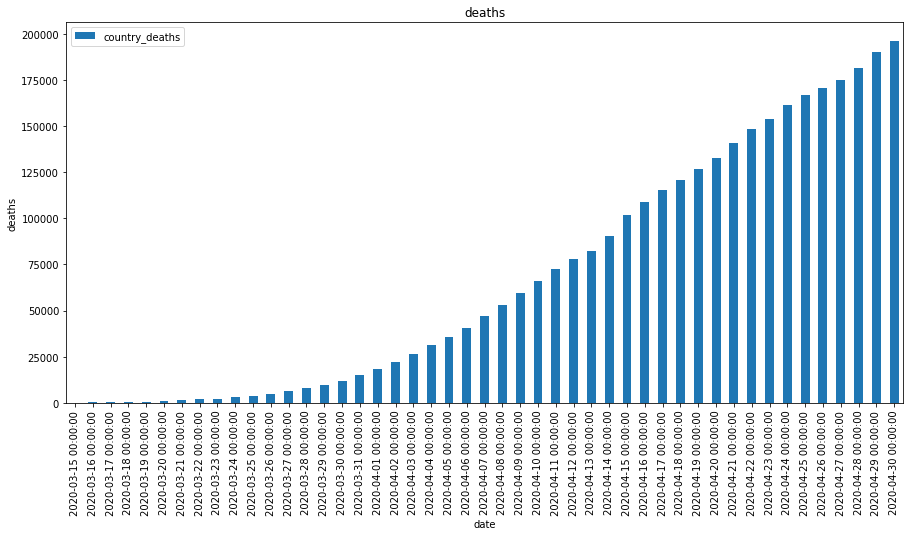

In [23]:
query = syntax.sql('''
SELECT
  date, SUM(cumulative_confirmed) AS country_cases,
  SUM(cumulative_deceased) AS country_deaths
FROM
  `bigquery-public-data.covid19_open_data.covid19_open_data`
WHERE
  date BETWEEN '2020-03-15'
  AND '2020-04-30'
  AND country_name='United States of America'
GROUP BY date
''')
df = pd.io.gbq.read_gbq(query, project_id=project_id, dialect='standard')

ax = df.plot(kind='bar',x='date',y='country_deaths',figsize=(15,7))
ax.set_title('deaths')
ax.set_xlabel('date')
ax.set_ylabel('deaths')